In [1]:
%matplotlib inline

In [2]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:
RAW_HASHED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/hashed_exec_resolution")
RAW_ATTENUATED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/forward_deferred")
RAW_TILED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/tiled_exec_resolution")

ANALYSIS_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/analysis/hashed_exec")

In [4]:
N_TESTS = 3
RESOLUTION = 2560

SCENES = {"pipers-alley": [ 0.2507,
                                                   0.507,
                                                   1.066666,
                                                   2.033,
                                                   3.31111,
                                 ],
              "ziggurat-city": [ 0.2499,
                                                    0.507,
                                                    1.07,
                                                    2.03,
                                                    3.18333,
              ],
              "spaceship-indoor": [0.24013,
                                                     0.507,
                                                     1.13,
                                                     2.13,
                                                     3.107,
              ],
         }

RESOLUTIONS = [320, 640, 960, 1280, 1920, 2560]



In [5]:
def json_to_dataframe(json_dic : dict) -> pd.DataFrame:
    '''
    Convert a json data file spit out by nTiled into something just slightly more useful
    '''
    # get all functions tracked from first frame
    frames = json_dic["frames"]
    functions = list(x for x in frames[0]["functions"])
    
    # build empty dictionary which will be loaded with data from frames
    data_raw = { fn : {} for fn in functions }    
    frames_i = {}
    
    for f in frames:
        f_i = int(f["frame"])
        frames_i[f_i] = f_i
        for fn in functions:
            if fn in f["functions"]:
                data_raw[fn][f_i] = float(f["functions"][fn])
            
    data_series = {fn : pd.Series(data_raw[fn], name=fn) for fn in functions }
    data_series["index"] = pd.Series(frames_i, name="index")
    
    dataframe = pd.DataFrame(data_series)
    return dataframe

In [6]:
def extract_resolution_data_frame_hashed(scene, node_size, pipeline_type):
    folder_path = RAW_HASHED_DATA_ROOT / Path("{}/{}/".format(pipeline_type, scene))
    
    output = pd.DataFrame([], columns=["execution_time", "resolution"])
    
    index = 0
    
    for res in RESOLUTIONS:
        res_path = folder_path / Path("{}/{}".format(res, SCENES[scene][node_size]))
        
        for i in range(N_TESTS):
            file_path = res_path / Path("data_{}.json".format(i))
            
            with open(str(file_path), 'r') as f:
                data_json = json.loads(f.read())
            df = json_to_dataframe(data_json)
            
            col_list = list(x for x in df if (x != 'index'))
            df_val = df[col_list].sum(axis=1).mean()

            output.loc[index] = [df_val, res]
            
            index += 1
    return output

In [7]:
def extract_resolution_data_frame_attenuated(scene, pipeline_type):
    mp = {"pipers-alley"    : "1044#3x_3y_2z",
          "ziggurat-city"   : "1170#3x_3y_2z",
          "spaceship-indoor": "1260#3x_3y_2z",
         }

    
    folder_path = RAW_ATTENUATED_DATA_ROOT / Path("{}/{}/{}/".format(pipeline_type, scene, mp[scene]))
    
    output = pd.DataFrame([], columns=["execution_time", "resolution"])
    
    index = 0
    
    for res in RESOLUTIONS:
        res_path = folder_path / Path("{}/".format(res))
        
        for i in range(N_TESTS):
            file_path = res_path / Path("data_{}.json".format(i))
            
            with open(str(file_path), 'r') as f:
                data_json = json.loads(f.read())
                
            df = json_to_dataframe(data_json)
            col_list = list(x for x in df if (x != 'index'))
            df_val = df[col_list].sum(axis=1).mean()

            output.loc[index] = [df_val, res]
            index += 1
    return output

In [8]:
def extract_resolution_data_frame_tiled(scene, pipeline_type):
    folder_path = RAW_TILED_DATA_ROOT / Path("{}/{}/".format(pipeline_type, scene))
    
    output = pd.DataFrame([], columns=["execution_time", "resolution"])
    
    index = 0
    
    for res in RESOLUTIONS:
        res_path = folder_path / Path("{}/".format(res))
        
        for i in range(N_TESTS):
            file_path = res_path / Path("data_{}.json".format(i))
            
            with open(str(file_path), 'r') as f:
                data_json = json.loads(f.read())
            df = json_to_dataframe(data_json)
            col_list = list(x for x in df if (x != 'index'))
            df_val = df[col_list].sum(axis=1).mean()

            output.loc[index] = [df_val, res]
            index += 1
    return output

In [9]:
def plot_resolution_plot(scene: str, pipeline_type: str):
    res_attenuated = extract_resolution_data_frame_attenuated(scene, pipeline_type)
    res_tiled = extract_resolution_data_frame_tiled(scene, pipeline_type)
    
    res_hashed = list(extract_resolution_data_frame_hashed(scene, i, pipeline_type) for i in range(5))

    # Plot resolution
    # -----------------------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("resolution", "execution_time", 
                data=res_attenuated, #fit_reg=False,
                ax=ax,
                label="Naief",
                x_estimator=np.mean,
                order=1,
                ci=100)
    sns.regplot("resolution", "execution_time", 
                data=res_tiled, #fit_reg=False,
                ax=ax,
                label="Tiled - 32",
                x_estimator=np.mean,
                order=1,
                ci=100)
    vals = [0.25, 0.5, 1.0, 2.0, 3.0]
    for x in range(5):
        sns.regplot("resolution", "execution_time", 
                    data=res_hashed[x], #fit_reg=False,
                    ax=ax,
                    label="Hashed - {}".format(vals[x]),
                    x_estimator=np.mean,
                    order=1,
                    ci=100)        
    
    ax.set(xlabel='Resolutie (px)', ylabel='Executietijd (ms)')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    ax.set(ylim=(-49, None))
    
    # Export file
    # -------------------------------------------------------------
    plt.show()

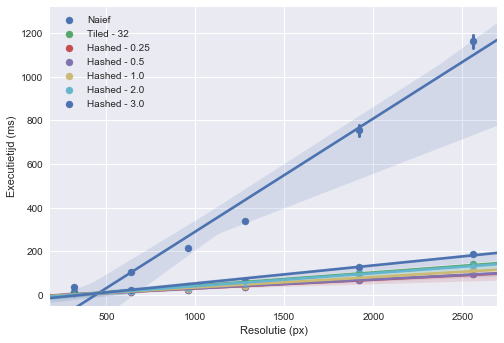

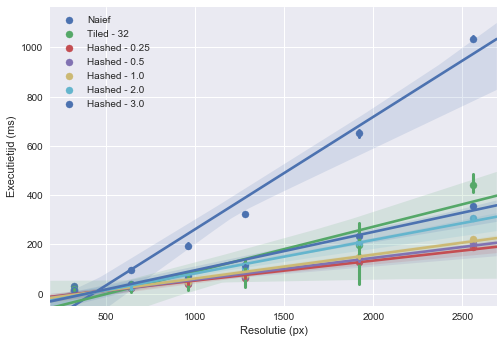

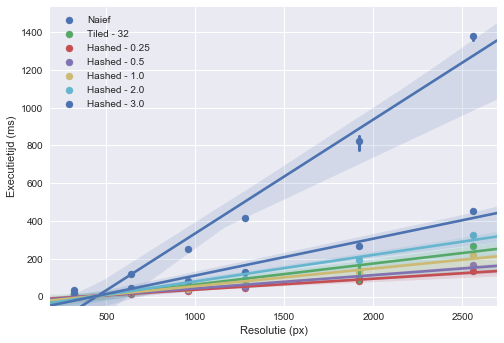

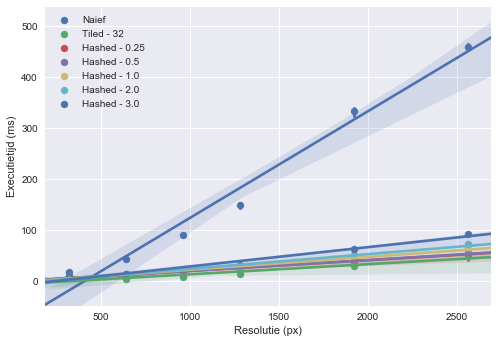

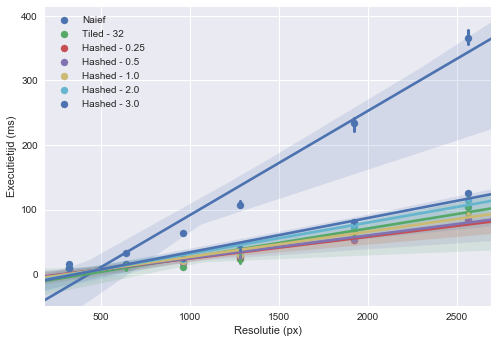

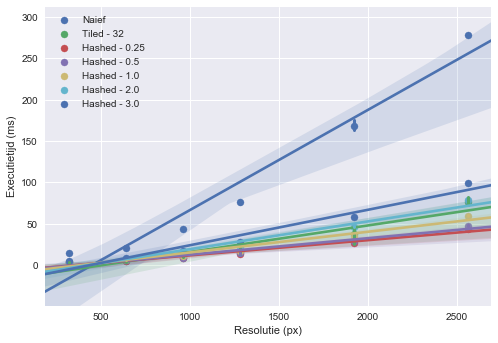

In [10]:
for pt in ["forward", "deferred"]:
    for scene in SCENES:
        plot_resolution_plot(scene, pt)

In [11]:
def export_resolution_plot(scene: str, pipeline_type: str):
    res_attenuated = extract_resolution_data_frame_attenuated(scene, pipeline_type)
    res_tiled = extract_resolution_data_frame_tiled(scene, pipeline_type)
    
    res_hashed = list(extract_resolution_data_frame_hashed(scene, i, pipeline_type) for i in range(5))

    # Plot resolution
    # -----------------------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("resolution", "execution_time", 
                data=res_attenuated, #fit_reg=False,
                ax=ax,
                label="Naief",
                x_estimator=np.mean,
                order=1,
                ci=100)
    sns.regplot("resolution", "execution_time", 
                data=res_tiled, #fit_reg=False,
                ax=ax,
                label="Tiled - 32",
                x_estimator=np.mean,
                order=1,
                ci=100)
    vals = [0.25, 0.5, 1.0, 2.0, 3.0]
    for x in range(5):
        sns.regplot("resolution", "execution_time", 
                    data=res_hashed[x], #fit_reg=False,
                    ax=ax,
                    label="Hashed - {}".format(vals[x]),
                    x_estimator=np.mean,
                    order=1,
                    ci=100)        
    
    ax.set(xlabel='Resolutie (px)', ylabel='Executietijd (ms)')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set(ylim=(-49, None))
    
    # Export file
    # -------------------------------------------------------------
    path = ANALYSIS_ROOT / Path("graphs/resolution/{}".format(pipeline_type))
    
    if not path.exists() or path.is_file():
        path.mkdir(parents=True)
        
    output_path = path / Path("resolution_{}.svg".format(scene))
    fig.savefig(str(output_path), bbox_inches='tight')
    plt.close(fig)

In [12]:
for pt in ["forward", "deferred"]:
    for scene in SCENES:
        export_resolution_plot(scene, pt)